In [1]:
import numpy as np
import do_mpc
from casadi import vertcat

import matplotlib.pyplot as plt
import matplotlib as mpl
# Customizing Matplotlib:
mpl.rcParams['font.size'] = 18
mpl.rcParams['lines.linewidth'] = 3
mpl.rcParams['axes.grid'] = True

In [2]:
model_type = 'continuous' # either 'discrete' or 'continuous'
model = do_mpc.model.Model(model_type)

In [3]:
δ = model.set_variable(var_type='_u', var_name='δ', shape=(1,1))
δ_m = model.set_variable(var_type='_x', var_name='δ_m', shape=(1,1))

u = model.set_variable(var_type='_x', var_name='u', shape=(1,1))
v = model.set_variable(var_type='_x', var_name='v', shape=(1,1))
r = model.set_variable(var_type='_x', var_name='r', shape=(1,1))
x = model.set_variable(var_type='_x', var_name='x', shape=(1,1))
y = model.set_variable(var_type='_x', var_name='y', shape=(1,1))
ψ = model.set_variable(var_type='_x', var_name='ψ', shape=(1,1))

In [4]:
K = model.set_variable(var_type='_p', var_name='K')
T = model.set_variable(var_type='_p', var_name='T')

In [5]:
model.set_rhs('u', vertcat(0.0))
model.set_rhs('v', vertcat(0.0))
model.set_rhs('r', 1.0 / T * (- r + K * δ ))
model.set_rhs('x', u * np.cos(ψ) - v * np.sin(ψ))
model.set_rhs('y', u * np.sin(ψ) + v * np.cos(ψ))
model.set_rhs('ψ', r)

In [6]:
model.set_rhs('δ_m', δ - δ_m)

In [7]:
model.setup()

In [8]:
mpc = do_mpc.controller.MPC(model)

n_horizon = 200
t_step = 1.0
n_robust = 1 # default to 0
store_full_solution = True

setup_mpc = {
    'n_horizon': n_horizon,
    't_step': t_step,
    'n_robust': n_robust,
    'store_full_solution': store_full_solution,
}

mpc.set_param(**setup_mpc)

In [9]:
target_y = 100.0
mterm =  (y - target_y)**2
lterm = (y - target_y)**2
mpc.set_objective(mterm=mterm, lterm=lterm)

In [10]:
mpc.set_rterm(δ = 1e-3)

In [11]:
mpc.bounds['lower','_u', 'δ'] = - 45 * np.pi / 180
mpc.bounds['upper','_u', 'δ'] = 45 * np.pi / 180

In [12]:
mpc.set_uncertainty_values(
    K = 0.15 * np.array([1.]),
    T = 80.0 * np.array([1.]),
)

In [13]:
mpc.setup()

In [14]:
simulator = do_mpc.simulator.Simulator(model)

In [15]:
simulator.set_param(t_step = 1)

In [16]:
p_template = simulator.get_p_template()
def p_fun(t_now):
    p_template['K'] = 0.15
    p_template['T'] = 80.0
    return p_template
simulator.set_p_fun(p_fun)

In [17]:
simulator.setup()

In [18]:
x0 = np.array([0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0]).reshape(-1,1)
simulator.x0 = x0
mpc.x0 = x0
mpc.set_initial_guess()

In [19]:
mpc.x0.keys()

['δ_m', 'u', 'v', 'r', 'x', 'y', 'ψ']

In [20]:
mpc_graphics = do_mpc.graphics.Graphics(mpc.data)
sim_graphics = do_mpc.graphics.Graphics(simulator.data)

In [21]:
%%capture
# We just want to create the plot and not show it right now. This "inline magic" supresses the output.
fig, ax = plt.subplots(3, sharex=True, figsize=(16,9))
fig.align_ylabels()

In [22]:
%%capture
for g in [sim_graphics, mpc_graphics]:
#     g.add_line(var_type='_x', var_name='x', axis=ax[0])
    g.add_line(var_type='_x', var_name='y', axis=ax[0])
    g.add_line(var_type='_x', var_name='ψ', axis=ax[1])
    g.add_line(var_type='_u', var_name='δ', axis=ax[2])
    
ax[0].set_ylabel('[m]')
ax[1].set_ylabel('azimuth [rad]')
ax[2].set_ylabel('delta [rad]')
ax[2].set_xlabel('time [s]')

In [23]:
# なぜか1回目はmemoryが足りないって怒られて変な値になるけど, 2回目に実行するととても良い解に収束する・・・なんだこれ
u0 = mpc.make_step(x0)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:    17607
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1800

Total number of variables............................:     5828
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      200
                     variables with only upper bounds:        0
Total number of equa

In [24]:
u0 = mpc.make_step(x0)

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:    17607
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1800

Total number of variables............................:     5828
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      200
                     variables with only upper bounds:        0
Total number of equality constraints.................:     5607
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

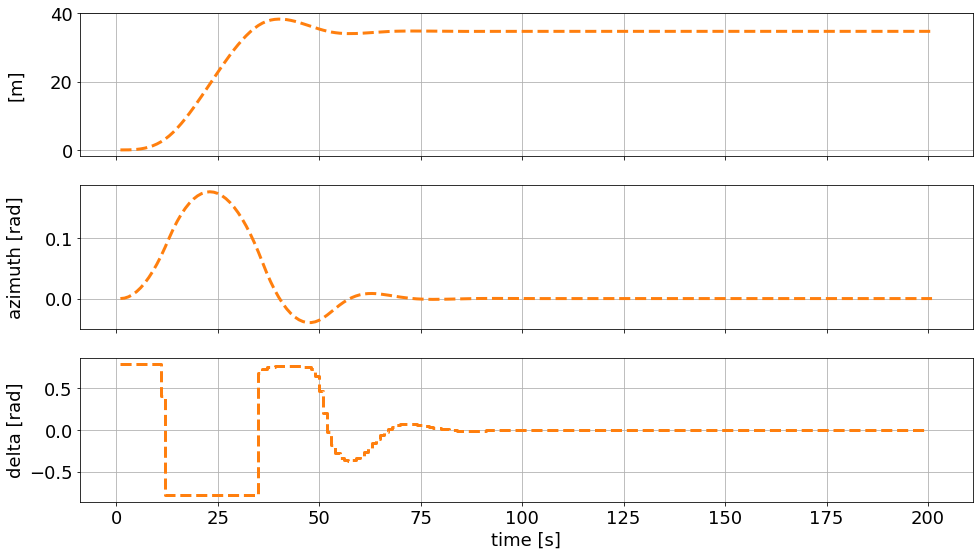

In [25]:
sim_graphics.clear()
mpc_graphics.plot_predictions()
mpc_graphics.reset_axes()
# Show the figure:
fig

In [26]:
simulator.reset_history()
simulator.x0 = x0
mpc.reset_history()

In [27]:
%%capture
for i in range(n_horizon):
    u0 = mpc.make_step(x0)
    x0 = simulator.make_step(u0)

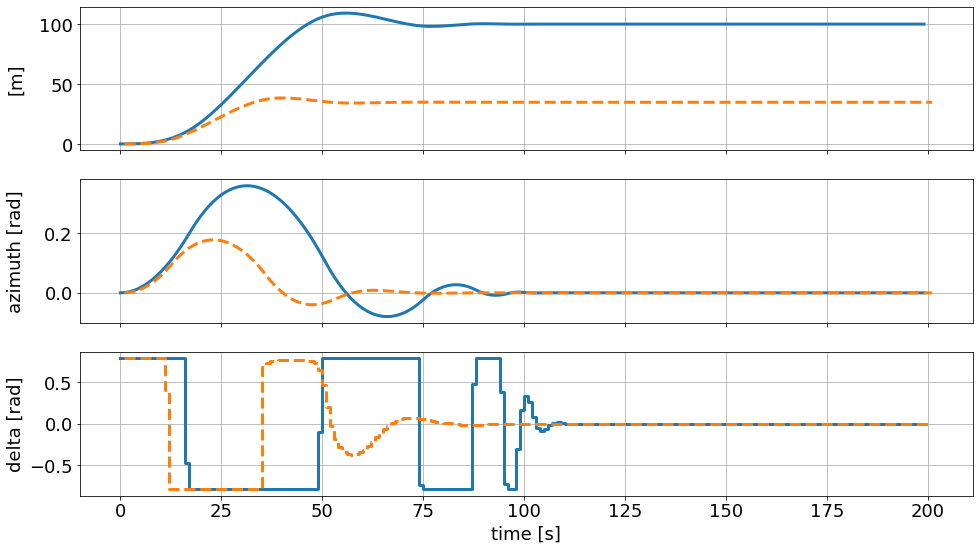

In [28]:
sim_graphics.clear()
mpc_graphics.clear()
# Plot predictions from t=0
# mpc_graphics.plot_predictions(t_ind=0)
# Plot results until current time
sim_graphics.plot_results()
sim_graphics.reset_axes()
fig

In [29]:
# remove past results
!rm -rf results/

# save present result
from do_mpc.data import save_results, load_results
save_results([mpc, simulator])
results = load_results('./results/results.pkl')

In [35]:
from shipmmg.ship_obj_3dof import ShipObj3dof
ship_kt = ShipObj3dof(L=80, B=10)
ship_kt.time  = np.linspace(0.00, n_horizon*t_step, n_horizon)
ship_kt.u = results['simulator']['_x','u'].reshape(-1)
ship_kt.v = results['simulator']['_x','v'].reshape(-1)
ship_kt.r = results['simulator']['_x','r'].reshape(-1)
ship_kt.x = results['simulator']['_x','x'].reshape(-1)
ship_kt.y = results['simulator']['_x','y'].reshape(-1)
ship_kt.psi = results['simulator']['_x','ψ'].reshape(-1)
ship_kt.δ = results['simulator']['_u','δ'].reshape(-1)

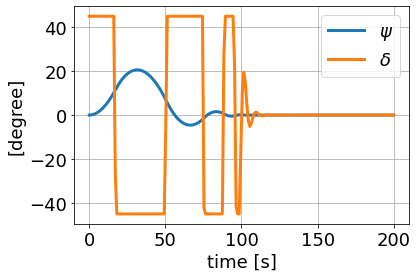

In [36]:
plt.plot(ship_kt.time, list(map(lambda ψ: ψ * 180 / np.pi ,ship_kt.psi)), label='$\psi$')
plt.plot(ship_kt.time, list(map(lambda δ: δ * 180 / np.pi ,ship_kt.δ)), label='$\delta$')
plt.xlabel('time [s]')
plt.ylabel('[degree]')
plt.legend();

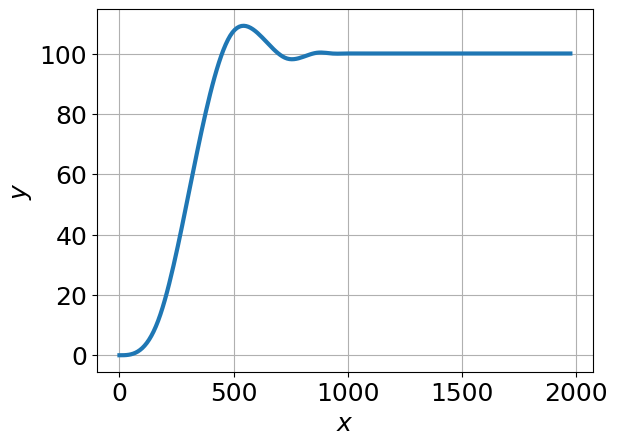

In [37]:
ship_kt.draw_xy_trajectory(aspect_equal=False)

In [38]:
ship_kt.draw_gif(frate=1, save_fig_path='demo.gif')